<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Amirreza Bagheri Delouee
### Student Number : 98109804
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [4]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

efigi_png downloaded!
efigi_tables downloaded!


,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


<Figure size 1000x800 with 0 Axes>

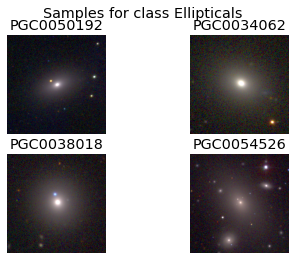

<Figure size 1000x800 with 0 Axes>

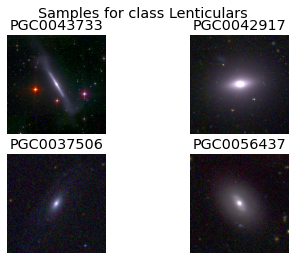

<Figure size 1000x800 with 0 Axes>

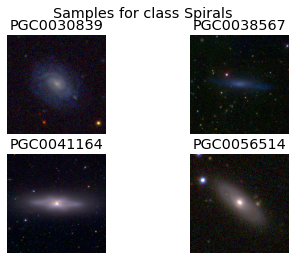

<Figure size 1000x800 with 0 Axes>

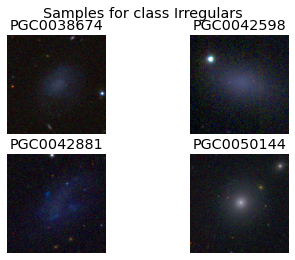

In [5]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################

for label in np.unique(df.class_label):
    samples = df[df["class_label"] == label].sample(n=4)
    sample_names = list(samples.name)
    class_name = (np.unique(samples.class_name))[0]
    
    plt.figure(figsize=(10, 8), dpi=100)
    f, axes = plt.subplots(2, 2)
    f.suptitle(f"Samples for class {class_name}", fontsize="x-large")
    plt.rcParams['axes.grid'] = False
    
    axes[0][0].imshow(plt.imread("./efigi-1.6/png/" + str(sample_names[0]) + ".png"));
    axes[0][0].axis('off')
    axes[0][0].set_title(sample_names[0])
    
    axes[0][1].imshow(plt.imread("./efigi-1.6/png/" + str(sample_names[1]) + ".png"));
    axes[0][1].axis('off')
    axes[0][1].set_title(sample_names[1])

    axes[1][0].imshow(plt.imread("./efigi-1.6/png/" + str(sample_names[2]) + ".png"));
    axes[1][0].axis('off')
    axes[1][0].set_title(sample_names[2])

    axes[1][1].imshow(plt.imread("./efigi-1.6/png/" + str(sample_names[3]) + ".png"));
    axes[1][1].axis('off')
    axes[1][1].set_title(sample_names[3])
    
    plt.show()

# Define Dataset (20 Points)

In [6]:
df['class_name'].value_counts()

Spirals        3315
Lenticulars     537
Irregulars      317
Ellipticals     289
Name: class_name, dtype: int64

In [7]:
new_df = df.copy()
new_df = new_df.drop(df[df['class_label'] == 2].sample(n=2500).index)
new_df['class_name'].value_counts()

Spirals        815
Lenticulars    537
Irregulars     317
Ellipticals    289
Name: class_name, dtype: int64

In [8]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        pass

    def __len__(self):
        return self.df.shape[0]
        pass

    def __getitem__(self, index):
        item_name = self.df['name'].iloc[index]
        image = PIL.Image.open("./efigi-1.6/png/"+ item_name + ".png")
        image = image.resize((64, 64))
        image = PIL.ImageOps.grayscale(image)
        target = self.df['class_label'].iloc[index]
        return self.transform(image), target

In [9]:
train_df, test_df = train_test_split(new_df, test_size=0.2, stratify=new_df['class_label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class_label'])

In [10]:
transform = transforms.Compose([transforms.ToTensor()])

galaxy_train_dataset = GalaxyDataSet(df=train_df, 
                                     transform=transform)

galaxy_val_dataset = GalaxyDataSet(df=val_df, 
                                   transform=transform)

galaxy_test_dataset = GalaxyDataSet(df=test_df, 
                                    transform=transform)

In [12]:
num_threads = 2
batch_size  = 255

train_loader = DataLoader(dataset=galaxy_train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_threads)

val_loader = DataLoader(dataset=galaxy_val_dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=num_threads)

test_loader = DataLoader(dataset=galaxy_test_dataset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=num_threads)

print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(val_loader.dataset), len(val_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 1252 images, in 5 batches
The validation set contains 314 images, in 2 batches
The test set contains 392 images, in 2 batches


# Define Model (20 Points)

In [13]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassifierModel, self).__init__()
        self.linear_1 = nn.Linear(input_size, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = nn.functional.relu(self.linear_1(x))
        x = nn.functional.relu(self.linear_2(x))
        y = self.linear_3(x)
        return y

# Train Model (30 Points)

In [14]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
def train(model, loader, f_loss, optimizer, device):
    model.train()

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [15]:
def update_confusion_matrix(conf_matrix, preds, reals):
    for i in range(len(reals)):
        conf_matrix[reals[i]][preds[i]] += 1
    return conf_matrix


def f1_score(confusion_matrix):
    TP = np.diag(confusion_matrix)
    FN = np.sum(confusion_matrix, axis=1) - TP
    FP = np.sum(confusion_matrix, axis=0) - TP
    f1_score = np.mean(TP/(TP + 1/2 * (FP+FN)))
    
    return f1_score

In [16]:
def test(model, loader, f_loss, device, num_classes):
    with torch.no_grad():
        model.eval()
        N = 0
        total_loss, correct = 0.0, 0.0
        confusion_matrix = np.zeros((num_classes, num_classes))
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.to(torch.float32)

            outputs = model(inputs)

            N += inputs.shape[0]

            total_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()

            update_confusion_matrix(conf_matrix=confusion_matrix, 
                                    preds=predicted_targets, 
                                    reals=targets)
            f1 = f1_score(confusion_matrix)
        return total_loss/N, correct/N, f1, confusion_matrix

In [17]:
num_classes = len(np.unique(df.class_label))
model = ClassifierModel(1*64*64, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
f_loss = torch.nn.CrossEntropyLoss()

In [18]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

epochs = 50

val_losses = []
val_accs = []
val_f1s = []
train_losses = []
train_accs = []
train_f1s = []

best_model = None
best_f1 = 0
for t in range(epochs):
    print("Epoch {}".format(t))
    train(model, train_loader, f_loss, optimizer, device)

    val_loss, val_acc, val_f1, _ = test(model, val_loader, f_loss, device, num_classes)
    train_loss, train_acc, train_f1, _ = test(model, train_loader, f_loss, device, num_classes)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    if (val_f1 > best_f1):
        best_model = model
        best_f1 = val_f1
    
    print(" Training : Loss : {:.4f}, Acc : {:.4f}, F1 : {:.4f}".format(train_loss, train_acc, train_f1))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}, F1: {:.4f}".format(val_loss, val_acc, val_f1))

Epoch 0
 Training : Loss : 1.3268, Acc : 0.4161, F1 : 0.1469
 Validation : Loss : 1.3298, Acc : 0.4172, F1: 0.1472
Epoch 1
 Training : Loss : 1.3052, Acc : 0.4193, F1 : 0.1558
 Validation : Loss : 1.3071, Acc : 0.4204, F1: 0.1533
Epoch 2
 Training : Loss : 1.2826, Acc : 0.4249, F1 : 0.1789
 Validation : Loss : 1.2863, Acc : 0.4331, F1: 0.1764
Epoch 3
 Training : Loss : 1.2585, Acc : 0.4177, F1 : 0.1579
 Validation : Loss : 1.2657, Acc : 0.4268, F1: 0.1650
Epoch 4
 Training : Loss : 1.2363, Acc : 0.4545, F1 : 0.2707
 Validation : Loss : 1.2423, Acc : 0.4586, F1: 0.2710
Epoch 5
 Training : Loss : 1.2046, Acc : 0.4585, F1 : 0.2987
 Validation : Loss : 1.2142, Acc : 0.4713, F1: 0.3081
Epoch 6
 Training : Loss : 1.1775, Acc : 0.4872, F1 : 0.3735
 Validation : Loss : 1.1876, Acc : 0.4745, F1: 0.3406
Epoch 7
 Training : Loss : 1.1536, Acc : 0.5040, F1 : 0.4420
 Validation : Loss : 1.1697, Acc : 0.5064, F1: 0.4147
Epoch 8
 Training : Loss : 1.1267, Acc : 0.5088, F1 : 0.4308
 Validation : Loss 

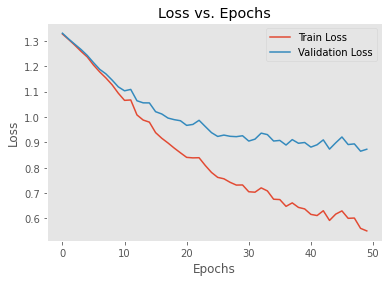

In [27]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

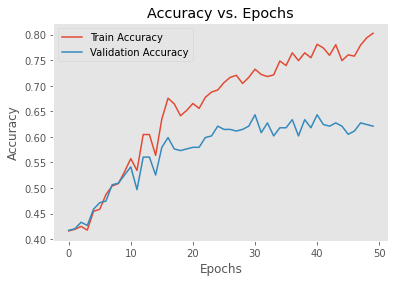

In [28]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

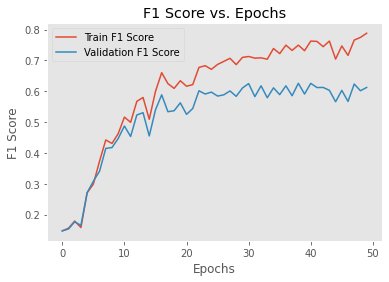

In [29]:
plt.plot(train_f1s, label='Train F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.title("F1 Score vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Test Model (20)

In [31]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_loss, test_acc, test_f1, confusion_matrix = test(best_model, test_loader, f_loss, device, num_classes)
print(" Test : Loss : {:.4f}, Acc : {:.4f}, F1: {:.4f}".format(test_loss, test_acc, test_f1))

 Test : Loss : 0.8975, Acc : 0.6301, F1: 0.6137


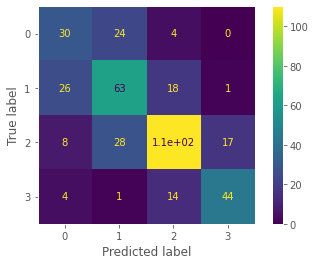

In [32]:
conf_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
conf_disp.plot()
plt.show()